## A life-cycle consumption  model under objective/subjective risk perceptions

- author: Tao Wang
- date: Feb 2022
- this is a companion notebook to the paper "Perceived income risks"

- This notebook builds on a standard life-cycle consumption model with uninsured income risks and extends it to allow subjective beliefs about income risks
  - Preference/income process

      - CRRA utility 
      - During work: labor income risk: permanent +persistent/transitory/2-state Markov between UE and EMP or between low and high risk + i.i.d. unemployment shock
       -  a deterministic growth rate of permanent income over the life cycle 
      - During retirement: receives a constant pension proportional to permanent income (no permanent/transitory income risks)
      - A positive probability of death before terminal age 
  

In [1]:
import numpy as np
from interpolation import interp
from numba import njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from Utility import cal_ss_2markov,mean_preserving_spread

In [2]:
from resources_jit import MeanOneLogNormal as lognorm

In [3]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

## The Model Class and Solver

In [4]:
lc_data = [
    ## model paras
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Real interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent state  x
    ('z_val', float64[:]),       # values of z, grid values for the continuous (macro) persistent state    x
    ('sigma_psi', float64),      # permanent shock volatility              x
    ('sigma_eps', float64),      # transitory shock volatility
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-permanent income
    ('b_y', float64),            # loading of macro state to income        x 
    ('borrowing_cstr',boolean),  ## artificial borrowing constraint if True, natural borrowing constraint if False
    ('U',float64),               # the i.i.d. probability of being unemployed    * 
    ('sigma_psi_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transitory risk, only 2 for now
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('sigma_p_init',float64),         ## standard deviation of initial income
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('LivPrb',float64),         # the probability of being alive next period 
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64),         ## zero: bequest thrown to the ocean; one: fully given to newborns
    ('theta',float64),           ## extrapolation parameter
    ## computational paras
    ('a_grid', float64[:]),      # Exogenous grid over savings
    ('eps_grid', float64[:]),    # Exogenous grid over transitory income shocks (for ma only)
    ('psi_shk_draws', float64[:]), ## draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # draws of MA/transitory income shocks 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('psi_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income
    ## regarding subjective beliefs
    ('P_sub',float64[:, :]),            # trans probs of belief states
    ('U2U_2mkv',float64[:]),            # state-dependent U2U prob
    ('E2E_2mkv',float64[:]),            # state-dependent E2E prob
    ('sigma_psi_true', float64),      # true permanent shock volatility              
    ('sigma_eps_true', float64),      # ture transitory shock volatility
    ('subjective',boolean),  ## belief is not necessarily equal to true 
    ('state_dependent_belief',boolean),  ## belief is state-dependent
    ('psi_shk_true_draws',float64[:]), ## draws of true permanent income shock 
    ('eps_shk_true_draws',float64[:]) ## draws of true transitory income shock 
]

In [5]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,    ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_psi = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent income shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = 0.995,       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65 (including 65)
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 7,
                 grid_max = 5.0,
                 grid_size = 50,
                 ## subjective state dependent 
                 subjective = False,
                 state_dependent_belief = False,
                 P_sub = np.array([[0.5,0.5],
                              [0.5,0.5]]), 
                 sigma_psi_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 U2U_2mkv = np.array([0.05,0.1]),         ## U2U in low and high risk mkv state
                 E2E_2mkv = np.array([0.95,0.9]),         ## E2E in low and high risk mkv state
                 theta = 2,               ## asymmetric extrapolation parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0,
                 sigma_psi_true = 0.10,     ## true size of permanent income shocks
                 sigma_eps_true = 0.10     ## ture size of transitory income risks  
                ): 
        self.ρ, self.β = ρ, β
        self.R = R 
        self.W = W
        self.P, self.z_val = P, z_val
        self.U = U
        #assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.subjective = subjective 

        ###################################################
        ## fork depending on subjective or objective model ##
        #####################################################

        self.sigma_psi = sigma_psi
        self.sigma_eps = sigma_eps
            
        if self.subjective==False:
            self.sigma_psi_true = self.sigma_psi
            self.sigma_eps_true = self.sigma_eps
        else:
            print('reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!')
            self.sigma_psi_true = sigma_psi_true
            self.sigma_eps_true = sigma_eps_true
            
        self.x = x
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ_SS
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 

        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        
        ## belief 
        self.P_sub = P_sub
        self.state_dependent_belief = state_dependent_belief
        self.sigma_psi_2mkv = sigma_psi_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
            
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        self.prepare_shocks()
        
        ## saving a grid
        self.a_grid = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size))

        ## extrapolation coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability (not needed if it is life-cycle)
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."  


    ## utility function 
    def u(self,c):
        if self.ρ!=1:
            return c**(1-self.ρ)/(1-ρ)
        elif self.ρ==1:
            return np.log(c)
    
    # marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    ## a function for the transitory/persistent income component
    ### the fork depending on if discrete-markov bool is on/off
    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to income
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            ## ump if z ==0 and emp if z==1
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)
        
    # a function from the log permanent shock to the income factor
    def Γ(self,psi_shk):
        return np.exp(psi_shk)
    
    
    def prepare_shocks(self):
        subjective = self.subjective
        shock_draw_size = self.shock_draw_size
        sigma_psi = self.sigma_psi
        sigma_eps = self.sigma_eps
        sigma_psi_true = self.sigma_psi_true
        sigma_eps_true = self.sigma_eps_true
        sigma_p_init = self.sigma_p_init
        sigma_psi_2mkv = self.sigma_psi_2mkv
        sigma_eps_2mkv = self.sigma_eps_2mkv
        
        ##################################################################
         ## discretized distributions 
        ##################################################################
                
        psi_shk_dist = lognorm(sigma_psi,100000,shock_draw_size)
        self.psi_shk_draws = np.log(psi_shk_dist.X)  ## the discretized is lognormal variable itself, we work with the log of it
        eps_shk_dist = lognorm(sigma_eps,100000,shock_draw_size)
        self.eps_shk_draws = np.log(eps_shk_dist.X)
        
        ## the draws used for simulation in household block 
        if subjective:
            psi_shk_true_dist = lognorm(sigma_psi_true,100000,shock_draw_size)
            eps_shk_true_dist = lognorm(sigma_eps_true,100000,shock_draw_size)
            self.psi_shk_true_draws =  np.log(psi_shk_true_dist.X)
            self.eps_shk_true_draws =  np.log(eps_shk_true_dist.X)
        else:
            self.psi_shk_true_draws =  self.psi_shk_draws
            self.eps_shk_true_draws =  self.eps_shk_draws
        
        init_p_dist = lognorm(sigma_p_init,100000,shock_draw_size)
        self.init_p_draws = np.log(init_p_dist.X)
        
        ## draw shocks for various markov state of volatility 
        #sigma_psi_2mkv_r = sigma_psi_2mkv.reshape(n_mkv,-1)
        #sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        sigma_psi_2mkv_l = lognorm(sigma_psi_2mkv[0],100000,shock_draw_size)
        sigma_psi_2mkv_h = lognorm(sigma_psi_2mkv[1],100000,shock_draw_size)
        
        self.psi_shk_mkv_draws = np.stack((np.log(sigma_psi_2mkv_l.X),
                                         np.log(sigma_psi_2mkv_h.X)))
        
        sigma_eps_2mkv_l = lognorm(sigma_eps_2mkv[0],100000,shock_draw_size)
        sigma_eps_2mkv_h = lognorm(sigma_eps_2mkv[1],100000,shock_draw_size)
        
        self.eps_shk_mkv_draws = np.stack((np.log(sigma_eps_2mkv_l.X),
                                         np.log(sigma_eps_2mkv_h.X)))
        
        
    def terminal_solution(self):
        
        k = len(self.a_grid)
        n_z =len(self.P)
        n_f = len(self.P_sub)
        σ_init = np.empty((k,n_z,n_f))
        m_init = np.empty((k,n_z,n_f))
        
        for z in range(n_z):
            for f in range(n_f):
                m_init[:,z,f] = np.exp(np.linspace(np.log(1e-6),
                                                   np.log(2*np.max(self.a_grid)),
                                                   len(self.a_grid)))
                σ_init[:,z,f] = m_init[:,z,f]
        return m_init,σ_init

In [6]:
## This function takes the consumption values at different 
## grids of state variables from period t+1, and
## the model class, then generates the consumption values at t.
## It depends on the age t since the income is different before 
## after the retirement. 

@njit
def EGM(mϵ_in,
        σ_in,
        age_id, ## the period id for which the c policy is computed, the first period age_id=0, last period age_id=L-1, retirement after age_id=T-1
        lc):
    """
    The recursive operator for the life-cycle consumption problem,
    using the endogenous grid method, From optimal c policy T to c policy T-1.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy
          * n1 = dim(a), n2 = dim(z), n3 = dim(belief)
        * mϵ_in is the same sized grid points of the three state variable
        * mϵ_in[:,z,f] is the vector of wealth grids corresponding to j-th grid of z and f-th grid of belief
        * σ_in[i,z,f] is consumption at mϵ_in[i,z,f]
    """
    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    ρ, β = lc.ρ, lc.β
    R = lc.R

    ## markov state
    P = lc.P
    z_val = lc.z_val

    ## belief
    P_sub = lc.P_sub
    state_dependent_belief = lc.state_dependent_belief
    psi_shk_mkv_draws = lc.psi_shk_mkv_draws
    eps_shk_mkv_draws  = lc.eps_shk_mkv_draws

    ## grid
    a_grid = lc.a_grid

    ## risks
    ue_prob = lc.U  ## uemp prob
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws

    ## model
    borrowing_cstr = lc.borrowing_cstr 
    LivProb = lc.LivPrb  ## live probability
    unemp_insurance = lc.unemp_insurance
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability

    ## income functions
    Y = lc.Y
    Γ = lc.Γ
    ####################################
    age = age_id + 1
    G = lc.G[age_id+1]  ## get the age specific growth rate, G[T] is the sudden drop in retirement from working age
    ####################################

    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    
    ###################
    n_z = len(P)
    n_f = len(P_sub)

    # Create consumption functions by linear interpolation
    σ = lambda m,z,f: interp(mϵ_in[:,z,f],σ_in[:,z,f], m)

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_a X grid_size_ϵ X grid_size_z

    # Obtain c_i at each a_i, z, store in σ_out[i, z], computing
    # the expectation term by computed by averaging over discretized equally probable points of the distributions
    for i, a in enumerate(a_grid):
        for z in range(n_z):
            for f in range(n_f):
                if state_dependent_belief ==False:
                    pass
                else:
                    psi_shk_draws = psi_shk_mkv_draws[f,:]
                    eps_shk_draws = eps_shk_mkv_draws[f,:]
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n_z):
                    z_val_hat = z_val[z_hat]
                    for f_hat in range(n_f):
                        for psi_shk in psi_shk_draws:
                            for eps_shk in eps_shk_draws:
                                ## for employed next period
                                Γ_hat = Γ(psi_shk)
                                if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes
                                    ## work
                                    Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,eps_shk) ## conditional on being employed
                                    c_hat = σ(R/(G*Γ_hat) * a + Y_hat+transfer,z_hat,f_hat)
                                    utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                    ## for unemployed next period
                                    Y_hat_u = (1-λ)*unemp_insurance
                                    c_hat_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer,z_hat,f_hat)
                                    utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)

                                    Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                               ue_prob*utility_u* P[z, z_hat]
                                              )*P_sub[f,f_hat]
                                else:
                                    ## retirement
                                    Y_R = lc.pension
                                    ## no income shocks affecting individuals
                                    Γ_hat = 1.0
                                    c_hat = σ(R/(G*Γ_hat) * a + (Y_R+transfer),z_hat,f_hat)
                                    utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                    Ez += LivProb*utility * P[z, z_hat]*P_sub[f,f_hat]
                            
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, z,f] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_out[i, z,f] =  adjust_prob/(1-LivProb*β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)

    for f in range(n_f):
        for z in range(n_z):
            mϵ_out[:,z,f] = a_grid + σ_out[:,z,f]

    # Fixing a consumption-asset pair at for the constraint region
    for f in range(n_f):
        for z in range(n_z):
            if borrowing_cstr:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,z,f] = 0.0
                mϵ_out[0,z,f] = 0.0
            #elif borrowing_cstr==False and ue_markov==True:
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                σ_out[0,z,f] = 0.0
                if state_dependent_belief:
                    self_min_a = - np.exp(np.min(eps_shk_mkv_draws[f,:]))*G/R
                else:
                    self_min_a = - np.exp(np.min(eps_shk_draws))*G/R
                self_min_a = min(self_min_a,-unemp_insurance/R)
                mϵ_out[0,z,f] = self_min_a

    return mϵ_out, σ_out

In [7]:
## the operator under markov stochastic risks 
## now the permanent and transitory risks are 
## different between markov states. 

@njit
def EGM_sv(mϵ_in, 
           σ_in, 
           age_id,
           lc):
    """
    The recursive operator for the life-cycle consumption problem,
    using the endogenous grid method, From optimal c policy T to c policy T-1.
    But the risks are stochastic state-dependent now.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy
          * n1 = dim(a), n2 = dim(z), n3 = dim(belief)
        * mϵ_in is the same sized grid points of the three state variable
        * mϵ_in[:,z,f] is the vector of wealth grids corresponding to j-th grid of z and f-th grid of belief
        * σ_in[i,z,f] is consumption at mϵ_in[i,z,f]
    """    

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    ρ, β = lc.ρ, lc.β
    R = lc.R

    a_grid = lc.a_grid
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    LivProb = lc.LivPrb  ## live probability
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability

    ## income functions
    Y = lc.Y
    Γ = lc.Γ
    ####################################
    ## life cycle
    age = age_id + 1
    G = lc.G[age_id+1]   ## get the age specific 
    ####################################    
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    pension = lc.pension
    
    ###################
    T = lc.T

    ###################
    # markov state
    P = lc.P
    z_val = lc.z_val
    n_z = len(P)

    ## belief
    P_sub = lc.P_sub
    n_f = len(P_sub)
    state_dependent_belief = lc.state_dependent_belief
    psi_shk_mkv_draws = lc.psi_shk_mkv_draws
    eps_shk_mkv_draws  = lc.eps_shk_mkv_draws

    # Create consumption function by linear interpolation
    σ = lambda m,z,f: interp(mϵ_in[:,z,f],σ_in[:,z,f], m)

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by averaging over different equally probable discrete points of shocks
    for i, a in enumerate(a_grid):
        for f in range(n_f):
            for z in range(n_z):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n_z):
                    z_val_hat = z_val[z_hat]
                    psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                    eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    for f_hat in range(n_f):
                        for eps_shk in eps_shk_draws:
                            for psi_shk in psi_shk_draws:
                                Γ_hat = Γ(psi_shk)
                                if age<=lc.T-1:
                                    # work
                                    Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,eps_shk) ## conditional on being employed
                                    c_hat = σ(R/(G*Γ_hat) * a + Y_hat+transfer,z_hat,f_hat)
                                    utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                    ## for unemployed next period
                                    Y_hat_u = (1-λ)*unemp_insurance
                                    c_hat_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer,z_hat,f_hat)
                                    utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                                    Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                                   ue_prob*utility_u* P[z, z_hat]
                                                  )*P_sub[f,f_hat]
                                else:
                                    ## retirement
                                    Y_R = lc.pension
                                    ## no income shocks affecting individuals
                                    Γ_hat = 1.0
                                    c_hat = σ(R/(G*Γ_hat) * a + (Y_R+transfer),z_hat,f_hat)
                                    utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                    Ez += LivProb*utility * P[z, z_hat]*P_sub[f,f_hat]
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, z,f] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <=1.0:
                    σ_out[i, z,f] =  adjust_prob/(1-β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)
                
    for f in range(n_f):
        for z in range(n_z):
            mϵ_out[:,z,f] = a_grid + σ_out[:,z,f]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for f in range(n_f):
        for z in range(n_z):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,z,f] = 0.0
                mϵ_out[0,z,f] = 0.0
            #elif borrowing_cstr==True or ue_markov==True:
            #    print('case2')
            #    σ_out[0,j,z] = 0.0
            #    aϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                if age <=T-1:
                    σ_out[0,z,f] = 0.0
                   
                    self_min_a = - np.exp(np.min(eps_shk_mkv_draws))*G/R 
                    ## the lowest among 2 markov states
                    self_min_a = min(self_min_a,-unemp_insurance/R)
                    mϵ_out[0,z,f] = self_min_a
                else:
                    σ_out[0,z,f] = 0.0
                    self_min_a = - pension*G/R
                    mϵ_out[0,z,f] = self_min_a


    return mϵ_out, σ_out

In [8]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter(model,        # Class with model information
                              mϵ_vec,        # Initial condition for assets and MA shocks
                              σ_vec,        # Initial condition for consumption
                             sv = False):

    ## memories for life-cycle solutions 
    n_a = σ_vec.shape[0]
    n_z = len(model.P)
    n_f = len(model.P_sub)
    mϵs_new =  np.empty((model.L,n_a,n_z,n_f),dtype = np.float64)
    σs_new =  np.empty((model.L,n_a,n_z,n_f),dtype = np.float64)
    
    mϵs_new[0,:,:,:] = mϵ_vec
    σs_new[0,:,:,:] = σ_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        print("at work age of "+str(age))
        mϵ_vec_next, σ_vec_next = mϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:]
        if sv ==False:
            #print('objective model without stochastic risk')
            mϵ_new, σ_new = EGM(mϵ_vec_next, σ_vec_next, age_id, model)
        else:
            #print('objective model with stochastic risk')
            mϵ_new, σ_new = EGM_sv(mϵ_vec_next, σ_vec_next, age_id, model)

        mϵs_new[year2L,:,:,:] = mϵ_new
        σs_new[year2L,:,:,:] = σ_new

    return mϵs_new, σs_new

In [9]:
## for infinite horizon problem 
def solve_model_iter(model,        # Class with model information
                     me_vec,        # Initial condition for assets and MA shocks
                     σ_vec,        # Initial condition for consumption
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50,
                      sv = False):
    
    
    # Test stability assuming {R_t} is IID and adopts the lognormal
    # specification given below.  The test is then β E R_t < 1.
    assert model.β * model.R < 1, "Stability condition failed."

    # Set up loop
    i = 0
    error = tol + 1

    ## plot
    fig,ax = plt.subplots()
    ax.plot(me_vec[:,0,0],
            σ_vec[:,0,0])
    ## memories for life-cycle solutions
    while i < max_iter and error > tol:
        if sv ==False:
            me_new, σ_new = EGM(me_vec, 
                                σ_vec, 
                                0,
                                model)
        else:
            #print('objective model with stochastic risk')
            mϵ_new, σ_new = EGM_sv(me_vec, 
                                   σ_vec, 
                                   0, 
                                   model)

        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
            ax.plot(me_new[:,0,0],
                     σ_new[:,0,0])
        me_vec, σ_vec = np.copy(me_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return me_vec, σ_vec

In [10]:
# a function to compare two solutions 

def compare_2solutions(ms_stars,
                      σs_stars):
    """
    input
    ======
    ms_stars: list of m grids
    σs_stars: list of c policies 
    
    output
    ======
    diff12: difference between solution 1 and solution 2 (1 minus 2)
    
    """
    if len(σs_stars)!=2 or len(σs_stars)!=2:
        print('only the first two solutions are compared!')
    m_star1, σ_star1 =ms_stars[0],σs_stars[0]
    m_star2, σ_star2 =ms_stars[1],σs_stars[1]

    ## get the interpolated c funcs
    c_stars1 = np.empty_like(σ_star1)
    c_stars2 = np.empty_like(σ_star2)
    n_age,n_m,n_eps,n_z = c_stars1.shape
    
    m_grid = np.linspace(0.0,5.0,n_m)
    
    for i in range(n_age):
        for j in range(n_eps):
            for k in range(n_z):
                c_func1 = lambda m: interp(m_star1[i,:,j,k],σ_star1[i,:,j,k],m)
                c_stars1[i,:,j,k] = c_func1(m_grid)
                c_func2 = lambda m: interp(m_star2[i,:,j,k],σ_star2[i,:,j,k],m)
                c_stars2[i,:,j,k] = c_func2(m_grid)
        
    diff12 = c_stars1-c_stars2
    return diff12 

## Initialize the model

In [11]:
if __name__ == "__main__":


    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk
    U0 = 0.0 ## transitory ue risk
    unemp_insurance = 0.15
    sigma_psi = 0.1 # permanent 
    sigma_eps = 0.0 # transitory 


    #λ = 0.0  ## tax rate
    #λ_SS = 0.0 ## social tax rate
    #transfer = 0.0  ## transfer 
    #pension = 1.0 ## pension


    ## life cycle 

    T = 40
    L = 60
    TGPos = int(L/3) ## one third of life sees income growth 
    GPos = 1.01*np.ones(TGPos)
    GNeg= 0.99*np.ones(L-TGPos)
    #G = np.concatenate([GPos,GNeg])
    G = np.ones(L)
    YPath = np.cumprod(G)


    ## other parameters 

    ρ = 2
    R = 1.01
    β = 0.97
    x = 0.0
    theta = 0.0 ## extrapolation parameter 

    ## no persistent state
    b_y = 0.0

    ## whether to have zero borrowing constraint
    borrowing_cstr = True

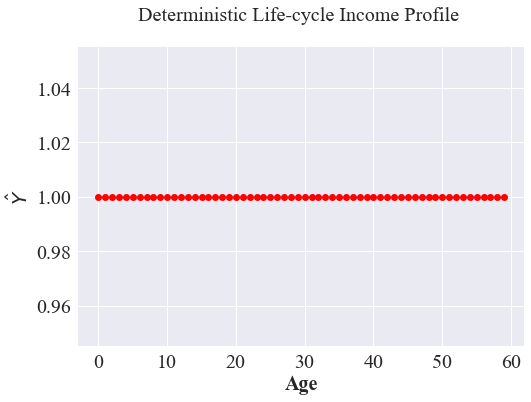

In [12]:
## a deterministic income profile 
if __name__ == "__main__":

    plt.title('Deterministic Life-cycle Income Profile \n')
    plt.plot(YPath,'ro')
    plt.xlabel('Age')
    plt.ylabel(r'$\hat Y$')

## Life-Cycle Problem 

### Consumption  the last period

In [13]:
if __name__ == "__main__":
    lc_basic = LifeCycle(sigma_psi = sigma_psi,
                   sigma_eps = sigma_eps,
                   U=U,
                   ρ=ρ,
                   R=R,
                   T=T,
                   L=L,
                   G=G,
                   β=β,
                   x=x,
                   borrowing_cstr = borrowing_cstr,
                   b_y= b_y,
                   unemp_insurance = unemp_insurance,
                   )

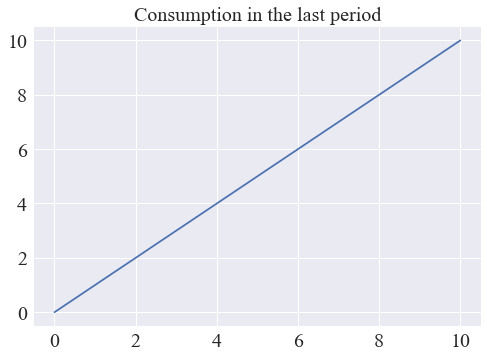

In [14]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 
    
    m_init,σ_init = lc_basic.terminal_solution()
    z_l = 0
    z_h = 1
    plt.title('Consumption in the last period')
    plt.plot(m_init[:,z_l,0],
             σ_init[:,z_l,0])

In [15]:
## Solve the basic model 

if __name__ == "__main__":


    t_start = time()


    ## terminal solution
    m_init,σ_init = lc_basic.terminal_solution()

    ## solve backward
    ms_star_basic, σs_star_basic = solve_model_backward_iter(lc_basic,
                                                 m_init,
                                                 σ_init)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

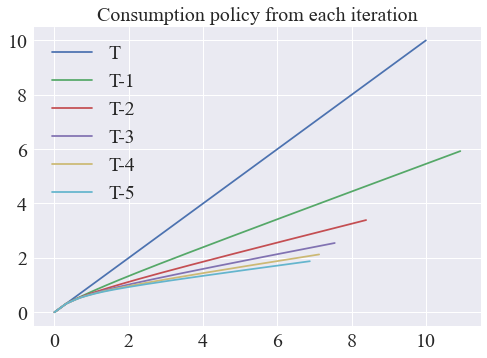

In [16]:
if __name__ == "__main__":
    #########################
    ## test the iteration
    #########################

    m_vec,σ_vec = lc_basic.terminal_solution()

    ### plot each iteration
    fig,ax = plt.subplots()
    plt.title('Consumption policy from each iteration')
    ax.plot(m_vec[:,0,0],
            σ_vec[:,0,0],
            label='T')

    ## solve backward

    for it in range(100):
        m_next, σ_next = EGM(m_vec,
                             σ_vec,
                             0,
                             lc_basic)
        if it <5:
            ax.plot(m_next[:,0,0],
                    σ_next[:,0,0],
                    label='T-'+str(it+1))
        error = np.max(abs(σ_next-σ_vec))
        m_vec = np.copy(m_next)
        σ_vec = np.copy(σ_next)
    ax.legend(loc=0)

## Infinite horizon 

Error at iteration 50 is 0.0006479195351021261.
Error at iteration 100 is 1.1920676943777408e-05.

Converged in 132 iterations.
Time taken, in seconds: 0.15938711166381836


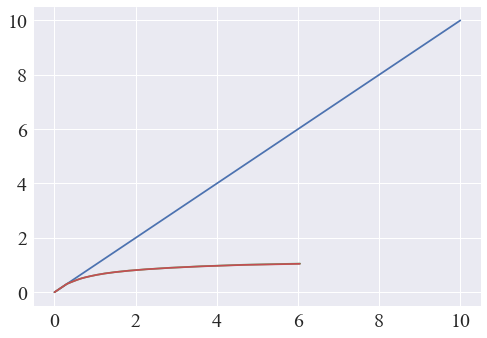

In [17]:
if __name__ == "__main__":


    ## initialize a model instance

    inf_liv1 = LifeCycle(sigma_psi = sigma_psi,
                       sigma_eps = sigma_eps,
                       U=U,
                       ρ=ρ,
                       R=R,
                       T=T,
                       L=L,
                       G=G,
                       β=β,
                       x=x,
                       borrowing_cstr = borrowing_cstr,
                       b_y= b_y,
                       unemp_insurance = unemp_insurance,
                       )


    ## initial guess of consumption functions 

    m_vec,σ_vec = inf_liv1.terminal_solution()
   
    t_start = time()

    m_inf_star, σ_inf_star = solve_model_iter(inf_liv1,
                                              m_vec,
                                              σ_vec,
                                             )

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   

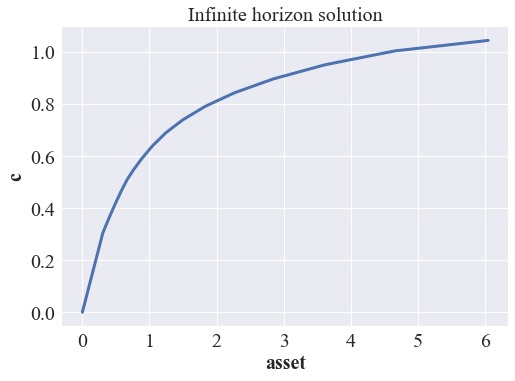

In [18]:
if __name__ == "__main__":
    ## plot c func 
    plt.plot(m_inf_star[:,0,0],
             σ_inf_star[:,0,0],
             lw=3)
    plt.xlabel('asset')
    plt.ylabel('c')
    plt.title('Infinite horizon solution')

## Infinite horizon with adjustment inertia

Error at iteration 50 is 0.006131781282199267.
Error at iteration 100 is 0.0038446695382661766.
Error at iteration 150 is 0.002516942726219662.
Error at iteration 200 is 0.0016477639052811244.
Error at iteration 250 is 0.0010787396417166473.
Error at iteration 300 is 0.0007062172019190877.
Error at iteration 350 is 0.0004623383780471696.
Error at iteration 400 is 0.00030267851764925746.
Error at iteration 450 is 0.0001981541861900242.
Error at iteration 500 is 0.00012972536607349684.
Error at iteration 550 is 8.492715156046757e-05.
Error at iteration 600 is 5.559915759334715e-05.
Error at iteration 650 is 3.6399034564214665e-05.
Error at iteration 700 is 2.3829312790981435e-05.
Error at iteration 750 is 1.5600307944669493e-05.
Error at iteration 800 is 1.0213035101063568e-05.
Error at iteration 850 is 6.68615557753772e-06.
Error at iteration 900 is 4.377217542548498e-06.
Error at iteration 950 is 2.8656278174505408e-06.
Error at iteration 1000 is 1.8760371647796566e-06.
Error at iterat

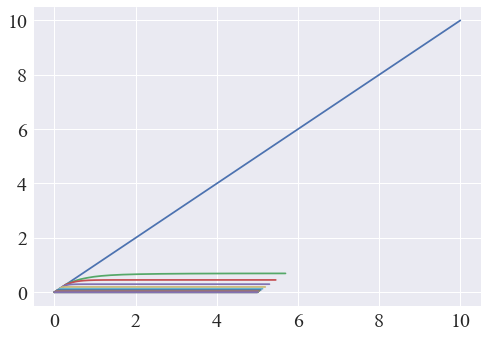

In [19]:
if __name__ == "__main__":

    ## Initialize a model instance
    
    imp_adjust = LifeCycle(sigma_psi = sigma_psi,
                           sigma_eps = sigma_eps,
                               U=U,
                               ρ=ρ,
                               R=R,
                               T=T,
                               L=L,
                               G=G,
                               β=β,
                               x=x,
                               borrowing_cstr = borrowing_cstr,
                               b_y= b_y,
                               unemp_insurance = unemp_insurance,
                               adjust_prob = 0.6
                           )
    
    ## initial consumption functions 
    m_init,σ_init = imp_adjust.terminal_solution()

    t_start = time()

    ## set different ma parameters
    m_imp_star, σ_imp_star = solve_model_iter(imp_adjust,
                                              m_init,
                                              σ_init)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))       

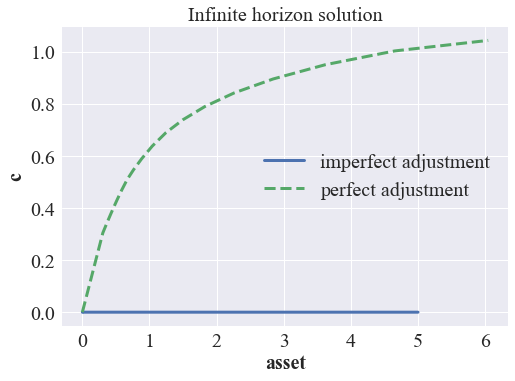

In [20]:
if __name__ == "__main__":
    ## plot c func at different age /asset grid

    plt.plot(m_imp_star[:,0,0],
             σ_imp_star[:,0,0],
             '-',
             label = 'imperfect adjustment',
             lw=3
            )
    plt.plot(m_inf_star[:,0,0],
             σ_inf_star[:,0,0],
             '--',
             label = 'perfect adjustment',
             lw=3
            )
    plt.legend()
    plt.xlabel('asset')
    plt.ylabel('c')
    plt.title('Infinite horizon solution')

### Different permanent/transitory risk (no MA)

In [21]:
if __name__ == "__main__":

    t_start = time()

    sigma_psi_ls = [0.03,0.2]
    sigma_eps_ls = [0.03,0.03]
    
    ms_stars =[]
    σs_stars = []
    for i,sigma_psi in enumerate(sigma_psi_ls):
        lc_basic.sigma_psi = sigma_psi
        lc_basic.sigma_eps = sigma_eps_ls[i]
        ### this line is very important!!!!
        #### need to regenerate shock draws for new sigmas
        lc_basic.prepare_shocks()
        
        ## terminal solution
        m_init,σ_init = lc_basic.terminal_solution()

        ## solve backward
        ms_star, σs_star = solve_model_backward_iter(lc_basic,
                                                     m_init,
                                                     σ_init)
        ms_stars.append(ms_star)
        σs_stars.append(σs_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

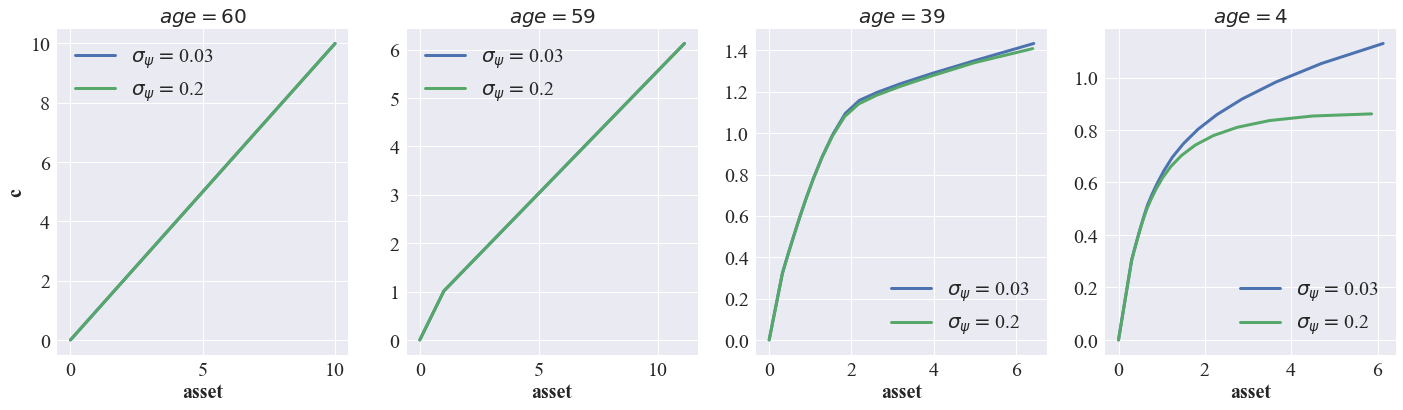

In [22]:
if __name__ == "__main__":


    ## plot c func at different age /asset grid
    years_left = [0,1,21,56]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age
        for k,sigma_psi in enumerate(sigma_psi_ls):
            m_plt,c_plt = ms_stars[k][i,:,1,1],σs_stars[k][i,:,1,1]
            axes[x].plot(m_plt,
                         c_plt,
                         label = r'$\sigma_\psi=$'+str(sigma_psi),
                         lw=3
                        )
        axes[x].legend()
        #axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

In [23]:
## the size of consumption function is  T x nb_a x nb_eps x nb_z 
if __name__ == "__main__":
    print(σs_star.shape)

(60, 50, 2, 2)


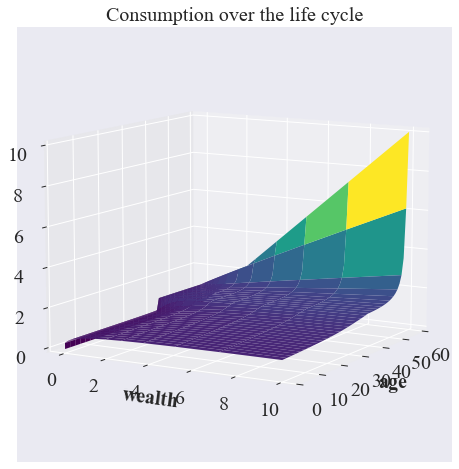

In [24]:
if __name__ == "__main__":

    ## plot 3d functions over life cycle 

    ages = np.array(range(ms_star.shape[0]))
    asset = ms_star[0,:,0,0]
    xx, yy = np.meshgrid(ages, asset)
    c_stars = np.flip(σs_star[:,:,0,0],axis=0).T

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, 
                         projection='3d')
    dem3d = ax.plot_surface(xx,
                            yy,
                            c_stars,
                            cmap="viridis"
                           )
    ax.set_xlim(60,0)
    ax.set_title('Consumption over the life cycle')
    ax.set_xlabel('age')
    #ax.grid(False)
    ax.set_ylabel('wealth')
    ax.view_init(10, 30)

### With a Markov/persistent state: good versus bad 

In [25]:
if __name__ == "__main__":
    ## initialize another 
    lc_ar = LifeCycle(sigma_psi=sigma_psi,
                     sigma_eps = sigma_eps,
                     U=U0,
                     ρ=ρ,
                     R=R,
                     T=T,
                     L=L,
                     G=G,
                     β=β,
                     x=0.0,  ## shut down ma(1)
                     borrowing_cstr = borrowing_cstr,
                     b_y=0.5)

In [26]:
if __name__ == "__main__":


    ## solve the model for different persistence 
    t_start = time()
    
    P = np.array([(0.9, 0.1),
                  (0.05, 0.95)])
    
    P_ls = [P]
    
    ms_stars_ar = []
    σs_stars_ar = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        
        lc_ar.P = P
        ## no need to reinitialize the model because P is only used in solving stage

        ## terminal solution
        m_init_ar,σ_init_ar = lc_ar.terminal_solution()

    
        ## solve the model 
        ms_star_ar, σs_star_ar = solve_model_backward_iter(lc_ar,
                                                         m_init_ar,
                                                         σ_init_ar)
        ms_stars_ar.append(ms_star_ar)
        σs_stars_ar.append(σs_star_ar)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

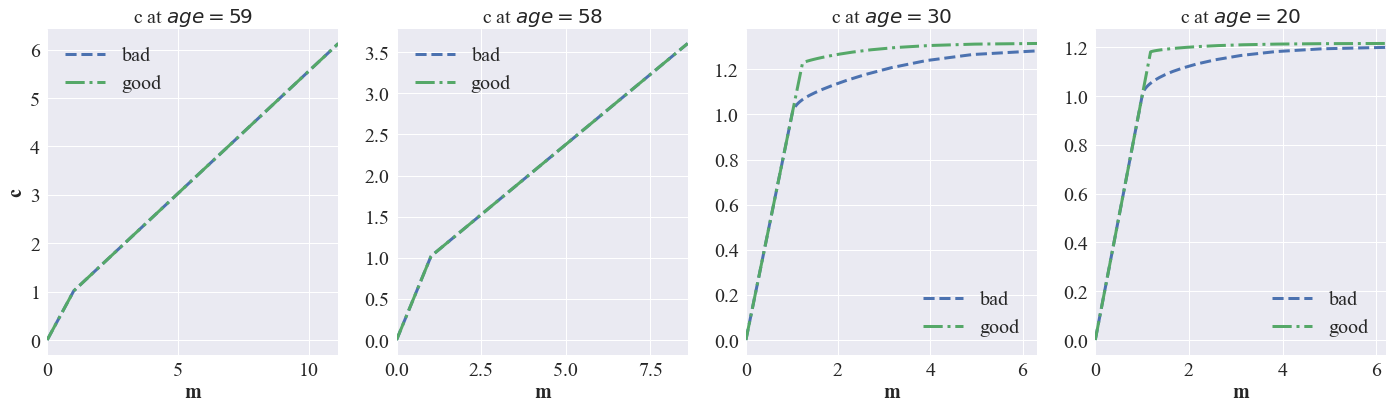

In [27]:
if __name__ == "__main__":


    ## compare two markov states good versus bad 

    years_left = [1,2,30,40]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_ar.L-year
        i = lc_ar.L-age
        z_l = 0
        z_h = 1
        m_plt_l,c_plt_l = ms_stars_ar[0][i,:,z_l,0],σs_stars_ar[0][i,:,z_l,0]
        m_plt_h,c_plt_h  = ms_stars_ar[0][i,:,z_h,0],σs_stars_ar[0][i,:,z_h,0]
        axes[x].plot(m_plt_l,
                     c_plt_l,
                     '--',
                     label ='bad',
                     lw=3)
        axes[x].plot(m_plt_h,
                     c_plt_h,
                     '-.',
                     label ='good',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_h)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c at $age={}$'.format(age))

### State-dependent risks 

In [28]:
if __name__ == "__main__":

    ## transition matrix between low and high risk state

    P = np.array([(0.5, 0.5),
                  (0.5, 0.5)])   # markov transition matrices

    ss_P = cal_ss_2markov(P)
    prob_l = P[0,0]
    prob_h = P[0,1]

    ## keep average risks the same 
     
    sigma_psi_2mkv = np.sqrt(
        mean_preserving_spread(
            mean = lc_basic.sigma_psi**2,
            probs = np.array([prob_l,prob_h]),
            l2mean_ratio = 0.1)
    )
    
    
    
    sigma_eps_2mkv = np.sqrt(
        mean_preserving_spread(
            mean = lc_basic.sigma_eps**2,
            probs = np.array([prob_l,prob_h]),
            l2mean_ratio = 0.1)
    )

    b_y = 0.0  ## set the macro state loading to be zero, i.e. only risks differ across two states

In [29]:
if __name__ == "__main__":
    ## compute steady state 
    av_sigma_psi = np.sqrt(np.dot(P[0,:],sigma_psi_2mkv**2))
    av_sigma_eps = np.sqrt(np.dot(P[0,:],sigma_eps_2mkv**2))
    print('steady state is '+str(ss_P))
    print('transitory probability is '+str(P[0,:]))
    print('average permanent risk is '+str(av_sigma_psi)+' compared to objective model '+str(lc_basic.sigma_psi))
    print('average transitory risk is '+str(av_sigma_eps)+' compared to objective model '+str(lc_basic.sigma_eps))

steady state is [0.5 0.5]
transitory probability is [0.5 0.5]
average permanent risk is 0.2 compared to objective model 0.2
average transitory risk is 0.03 compared to objective model 0.03


In [30]:
if __name__ == "__main__":

    print('permanent risk state is '+str(sigma_psi_2mkv))
    print('transitory risk state is '+str(sigma_eps_2mkv))

permanent risk state is [0.06324555 0.27568098]
transitory risk state is [0.00948683 0.04135215]


In [31]:
if __name__ == "__main__":

    ## another model instance 

    lc_sv = LifeCycle(sigma_psi = sigma_psi,
                   sigma_eps = sigma_eps,
                   U=U,
                   ρ=ρ,
                   R=R,
                   T=T,
                   L=L,
                   G=G,
                   β=β,
                   x=x,
                   sigma_psi_2mkv = sigma_psi_2mkv,
                   sigma_eps_2mkv = sigma_eps_2mkv,
                   borrowing_cstr = borrowing_cstr,
                   b_y=b_y)

In [32]:
if __name__ == "__main__":

    ## solve the model for different transition matrices 

    t_start = time()

    P_ls = [P]
    ms_stars_sv = []
    σs_stars_sv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_sv.P = P

        ## terminal solution       
        m_init_sv,σ_init_sv = lc_sv.terminal_solution()

        ## solve the model 
        ms_star_sv, σs_star_sv = solve_model_backward_iter(lc_sv,
                                                           m_init_sv,
                                                           σ_init_sv,
                                                           sv = True)
        ms_stars_sv.append(ms_star_sv)
        σs_stars_sv.append(σs_star_sv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

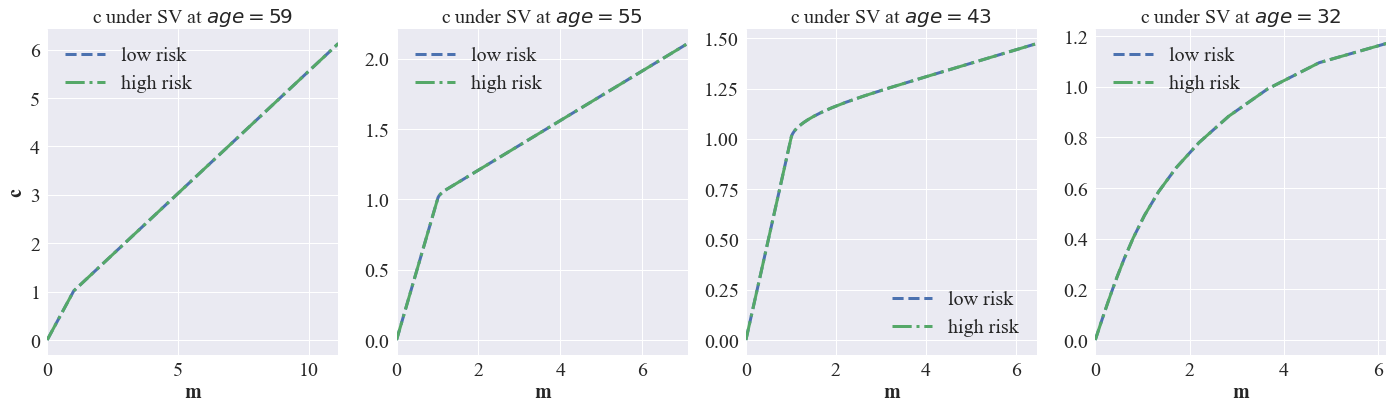

In [33]:
if __name__ == "__main__":
    ## compare two markov states low versus high risk 

    years_left = [1,5,17,28]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age
        z_l = 0
        z_h = 1
        m_plt_l,c_plt_l = ms_stars_sv[0][i,:,z_l,0],σs_stars_sv[0][i,:,z_l,0]
        m_plt_h,c_plt_h = ms_stars_sv[0][i,:,z_h,0],σs_stars_sv[0][i,:,z_h,0]
        
        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='low risk',
                     lw=3)
        
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='high risk',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_h)))

        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under SV at $age={}$'.format(age))

### Comparison: objective and subjective risk perceptions

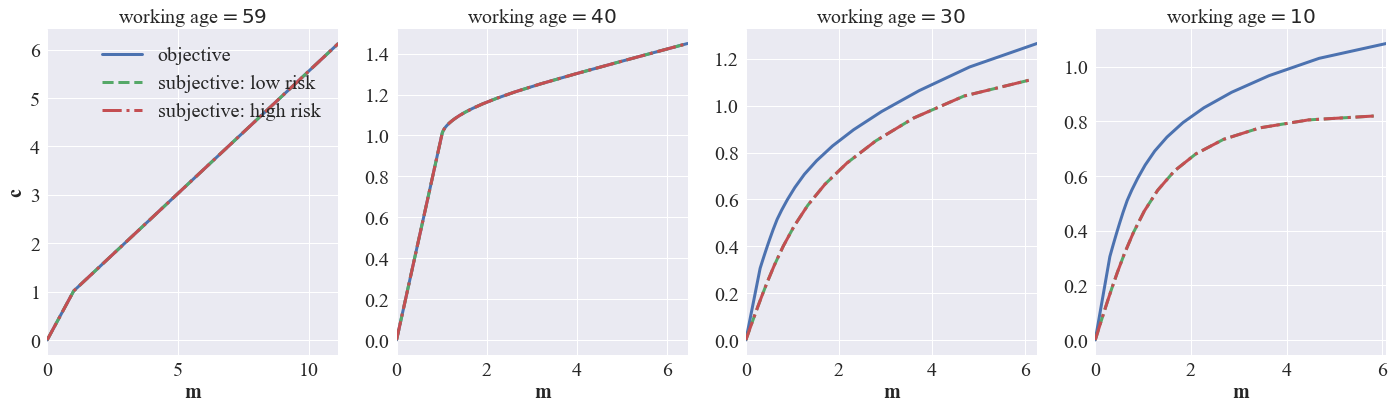

In [34]:
if __name__ == "__main__":

    ## compare subjective and objective models 
    years_left = [1,20,30,50]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age

        z_l = 0
        z_h = 1

        ## baseline: no ma shock 
        m_plt,c_plt = ms_star_basic[i,:,z_l,0],σs_star_basic[i,:,z_l,0]
        axes[x].plot(m_plt,
                     c_plt,
                     label = 'objective',
                     lw=3)
        z_l = 0
        z_h = 1
        m_plt_l,c_plt_l = ms_stars_sv[0][i,:,z_l,0],\
                          σs_stars_sv[0][i,:,z_l,0]
        m_plt_h,c_plt_h = ms_stars_sv[0][i,:,z_h,0],\
                          σs_stars_sv[0][i,:,z_h,0]

        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='subjective: low risk',
                     lw=3)
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='subjective: high risk',
                     lw=3)


        axes[0].legend()
        axes[x].set_xlim((0.0,np.max(m_plt)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    #plt.suptitle('Various Straight Lines',fontsize=20)

    fig.savefig('../Graphs/model/comparison1.png')

### With a Markov/persistent unemployment state

In [35]:
if __name__ == "__main__":


    ## transition matrix between emp and uemp

    ## transition probability during normal times of the economy 

    P_uemkv = np.array([(0.2, 0.8),
                        (0.2, 0.8)])   # markov transition matrices

    #P_uemkv = np.array([(0.4, 0.6),
    #                    (0.05, 0.95)])   # markov transition matrices

In [36]:
if __name__ == "__main__":

    ## initialize another 
    lc_uemkv = LifeCycle(sigma_psi=sigma_psi,
                         sigma_eps = sigma_eps,
                         U=U0,
                         ρ=ρ,
                         R=R,
                         T=T,
                         L=L,
                         G=G,
                         β=β,
                         x=0.0,  ## shut down ma(1)
                         borrowing_cstr = borrowing_cstr,
                         b_y = 0.0, ## markov state loading does not matter any more 
                         unemp_insurance = 0.3,
                         ue_markov = True)

In [37]:
if __name__ == "__main__":

    ## solve the model for different transition matrices of UE markov
    t_start = time()

    P_ls = [P_uemkv]
    ms_stars_uemkv=[]
    σs_stars_uemkv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_uemkv.P = P

        ## terminal solution
        m_init_uemkv,σ_init_uemkv = lc_uemkv.terminal_solution()

        ## solve the model 
        ms_star_uemkv, σs_star_uemkv = solve_model_backward_iter(lc_uemkv,
                                                                 m_init_uemkv,
                                                                 σ_init_uemkv,
                                                                 sv = False)
        ms_stars_uemkv.append(ms_star_uemkv)
        σs_stars_uemkv.append(σs_star_uemkv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

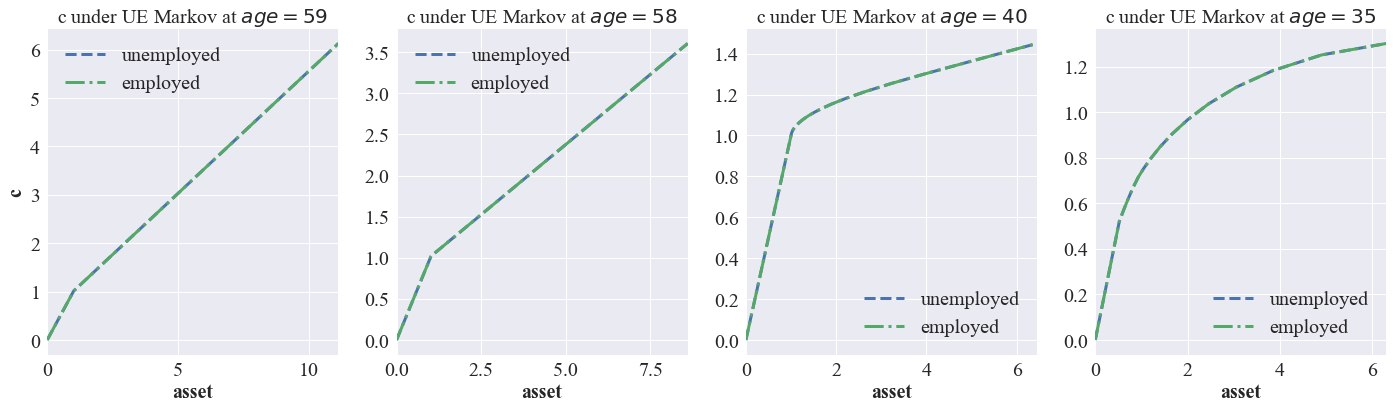

In [38]:
if __name__ == "__main__":


    ## compare two markov states of emp and uemp 

    years_left = [1,2,20,25]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_uemkv.L-year
        i = lc_uemkv.L-age
        z_l = 0
        z_h = 1
        m_plt_u, c_plt_u = ms_stars_uemkv[0][i,:,z_l,0],σs_stars_uemkv[0][i,:,z_l,0]
        m_plt_e, c_plt_e = ms_stars_uemkv[0][i,:,z_h,0],σs_stars_uemkv[0][i,:,z_h,0]

        axes[x].plot(m_plt_u, ## 0 indicates the low risk state 
                     c_plt_u,
                     '--',
                     label ='unemployed',
                     lw=3)
        axes[x].plot(m_plt_e, ## 1 indicates the high risk state 
                     c_plt_e,
                     '-.',
                     label ='employed',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_e)))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under UE Markov at $age={}$'.format(age))

### "Countercylical" risks

- unemployed perceive higher risks


In [39]:
if __name__ == "__main__":


    ss_P_cr= cal_ss_2markov(P_uemkv)
    prob_h_cr = P_uemkv[0,0]
    prob_l_cr = P_uemkv[0,1]

    ## keep average risks the same 
    ### notice here I put high risk at the first!!!
    sigma_psi_2mkv_cr = np.sqrt(mean_preserving_spread(mean = lc_uemkv.sigma_psi**2,
                                                      probs = np.array([prob_l_cr,prob_h_cr]),
                                                      l2mean_ratio = 0.1)
                               )
    ### notice here I put high risk at the first!!!
    sigma_psi_2mkv_cr = np.flip(sigma_psi_2mkv_cr)
    ### notice here I put high risk at the first!!!
    
    sigma_eps_2mkv_cr = np.sqrt(mean_preserving_spread(mean = lc_uemkv.sigma_eps**2,
                                                      probs = np.array([prob_l_cr,prob_h_cr]),
                                                      l2mean_ratio = 0.1)
                               )
    ### notice here I put high risk at the first!!!
    sigma_eps_2mkv_cr = np.flip(sigma_eps_2mkv_cr)
   ### notice here I put high risk at the first!!!


    ## again, zero loading from z
    b_y = 0.0

In [40]:
if __name__ == "__main__":
    ## compute steady state 
    av_sigma_psi_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_psi_2mkv_cr**2))
    av_sigma_eps_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_eps_2mkv_cr**2))
    print('steady state is '+str(ss_P_cr))
    print('transitory probability is '+str(P_uemkv[0,:]))

    print('average permanent risk is '+str(av_sigma_psi_cr)+' compared to objective model '+str(lc_uemkv.sigma_psi))
    print('average transitory risk is '+str(av_sigma_eps_cr)+' compared to objective model '+str(lc_uemkv.sigma_eps))

steady state is [0.2 0.8]
transitory probability is [0.2 0.8]
average permanent risk is 0.20000000000000004 compared to objective model 0.2
average transitory risk is 0.0 compared to objective model 0.0


In [41]:
if __name__ == "__main__":


    ## model instance 
    lc_cr= LifeCycle(sigma_psi = sigma_psi,
                     sigma_eps = sigma_eps,
                     U=U0,
                     ρ=ρ,
                     P=P, 
                     R=R,
                     T=T,
                     L=L,
                     G=G,
                     β=β,
                     sigma_psi_2mkv = sigma_psi_2mkv_cr,   # different 
                     sigma_eps_2mkv = sigma_eps_2mkv_cr,  # different 
                     shock_draw_size = 30,
                     borrowing_cstr = borrowing_cstr,
                     x = x,  ## shut down ma(1)
                     b_y = b_y,
                     ue_markov = True)

In [42]:
if __name__ == "__main__":


    ## solve the model for different transition matrices

    t_start = time()

    P_ls = [P_uemkv]
    ms_stars_cr=[]
    σs_stars_cr = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_cr.P = P

        ## initial guess
        m_init_cr,σ_init_cr =lc_cr.terminal_solution()

        ## solve the model 
        ms_star_cr, σs_star_cr = solve_model_backward_iter(lc_cr,
                                                           m_init_cr,
                                                           σ_init_cr,
                                                           sv = True)
        ms_stars_cr.append(ms_star_cr)
        σs_stars_cr.append(σs_star_cr)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

at work age of 59
at work age of 58
at work age of 57
at work age of 56
at work age of 55
at work age of 54
at work age of 53
at work age of 52
at work age of 51
at work age of 50
at work age of 49
at work age of 48
at work age of 47
at work age of 46
at work age of 45
at work age of 44
at work age of 43
at work age of 42
at work age of 41
at work age of 40
at work age of 39
at work age of 38
at work age of 37
at work age of 36
at work age of 35
at work age of 34
at work age of 33
at work age of 32
at work age of 31
at work age of 30
at work age of 29
at work age of 28
at work age of 27
at work age of 26
at work age of 25
at work age of 24
at work age of 23
at work age of 22
at work age of 21
at work age of 20
at work age of 19
at work age of 18
at work age of 17
at work age of 16
at work age of 15
at work age of 14
at work age of 13
at work age of 12
at work age of 11
at work age of 10
at work age of 9
at work age of 8
at work age of 7
at work age of 6
at work age of 5
at work age of 

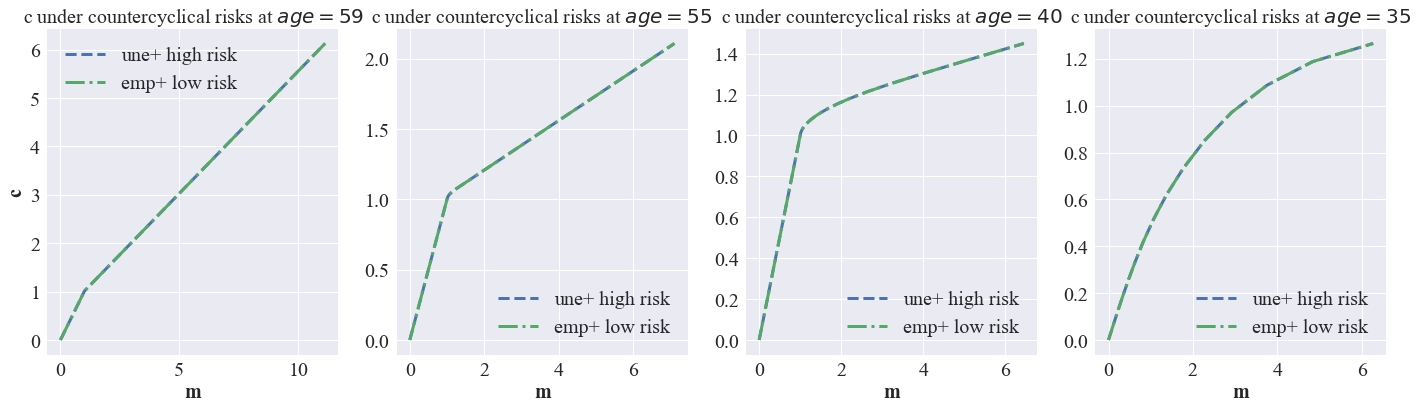

In [43]:
if __name__ == "__main__":

    ## compare two markov states low versus high risk 

    years_left = [1,5,20,25]

    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age
        m_plt_l,c_plt_l = ms_stars_cr[0][i,:,z_l,0],\
                          σs_stars_cr[0][i,:,z_l,0]
        m_plt_h,c_plt_h = ms_stars_cr[0][i,:,z_h,0],\
                          σs_stars_cr[0][i,:,z_h,1]
        
        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='une+ high risk',
                     lw = 3)
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='emp+ low risk',
                     lw = 3)
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under countercyclical risks at $age={}$'.format(age))

### Objective and subject state-dependent profile

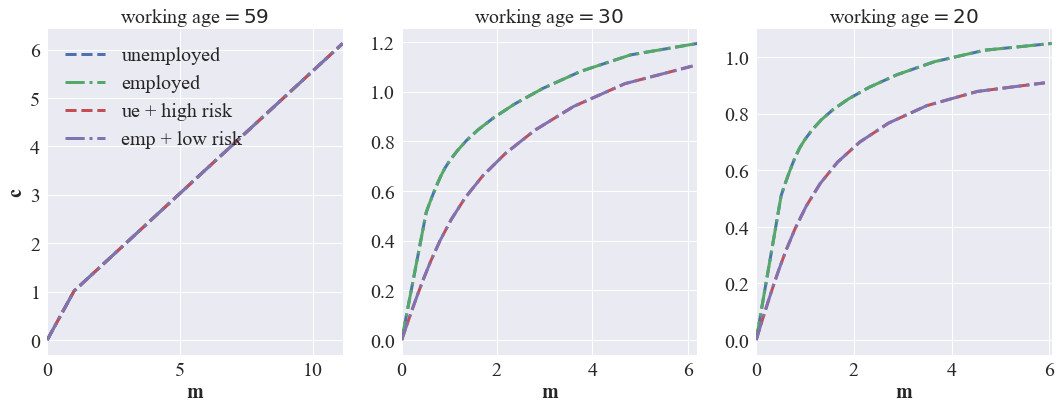

In [44]:
if __name__ == "__main__":

    ## compare subjective and objective models 

    years_left = [1,30,40]


    n_sub = len(years_left)

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_basic.L-year
        i = lc_basic.L-age
        ## persistent
        m_plt_u, c_plt_u = ms_stars_uemkv[0][i,:,z_l,0],σs_stars_uemkv[0][i,:,z_l,0]
        m_plt_e, c_plt_e = ms_stars_uemkv[0][i,:,z_h,0],σs_stars_uemkv[0][i,:,z_h,0]
        axes[x].plot(m_plt_u,
                     c_plt_u,
                     '--',
                     label ='unemployed',
                     lw=3)
        axes[x].plot(m_plt_e,
                     c_plt_e,
                     '-.',
                     label ='employed',
                     lw=3)

        ## countercyclical
        m_plt_l,c_plt_l = ms_stars_cr[0][i,:,z_l,0],σs_stars_cr[0][i,:,z_l,0]
        m_plt_h,c_plt_h = ms_stars_cr[0][i,:,z_h,0],σs_stars_cr[0][i,:,z_h,0]
        axes[x].plot(m_plt_l, ## 0 indicates the low risk state
                 c_plt_l,
                 '--',
                 label ='ue + high risk',
                 lw=3)
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state
                     c_plt_h,
                     '-.',
                     label ='emp + low risk',
                     lw=3)

        axes[0].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_e)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    #plt.suptitle('Various Straight Lines',fontsize=20)

    fig.savefig('../Graphs/model/comparison2.png')
